In [1]:
import numpy as np
import matplotlib.pyplot as plt


from hnc_n_multiscale import  HNC_solver
from qsps import *

# Two Species

Here we do QSP interactions between electrons and one ion type. 

Using $\tilde{r}\equiv r/r_s$, we implement potentials 
\begin{align}
\beta v_{ee}(\tilde{r}) &=  \frac{\Gamma_{ee}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right) +  \ln2 \exp\left[-\tilde{r}^2 r_s^2/(\pi \Lambda_e^2 \ln 2)\right]\\
\beta v_{ei}(\tilde{r}) &=  \frac{\Gamma_{ei}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right)\\
\beta v_{ii}(\tilde{r}) &=  \frac{\Gamma_{ii}}{\tilde{r}}
\end{align}
For  
\begin{align}
\Gamma_{ee}&=\frac{\beta e^2}{r_s}\\
\Gamma_{ei}&=\frac{\beta Z_i e^2}{r_s}\\
\Gamma_{ii}&=\frac{\beta Z_i^2 e^2}{r_s}\\
\end{align}

Plug into get potentials

In [2]:
# ri = QSP_HNC.rs_from_n(6.03e30*aB**3)
ri = 3
Te_c = 50*eV 
Ti   = 50*eV 
Z, A = 13, 27
Zstar= 3
# "Classical-Map  Hypernetted  Chain  Calculations  for  DensePlasmas"R. Bredow1∗, Th. Bornath1, W.-D. Kraeft1, M.W.C. Dharma-wardana2,andR. Redmer1
# Tq  = 1/5*qsp.E_F 


def make_Te(Te_c, Tq):
    Te  = np.sqrt(Tq**2 + Te_c**2)
    return Te
    
qsp = QSP_HNC(Z, A, Zstar, Te_c, Ti, ri)
# Tq = 200*1/5*qsp.E_F 
# qsp = QSP_HNC(Z, A, Zstar, make_Te(Te_c, Tq), Ti, ri)


Λee = 0.188
Λei = 0.133
Γii=1.6, Γie=-0.5, Γee=0.2 
r_i=3.0
r_e=2.1


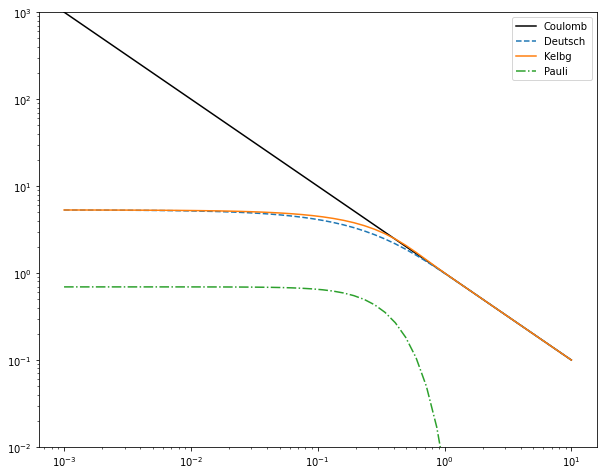

In [3]:

fig, ax = plt.subplots(figsize=(10,8),facecolor='w')

xs = np.geomspace(1e-3,10)
ax.plot(xs, 1/xs,'-k',label='Coulomb')
ax.plot(xs,qsp.βv_Deutsch(1,xs, qsp.Λee),'--',label='Deutsch')
ax.plot(xs,qsp.βv_Kelbg(1,xs,qsp.Λee),label='Kelbg')
ax.plot(xs,qsp.βv_Pauli(xs,qsp.Λee),'-.',label='Pauli')

# ax.plot(xs, qsp.βvee(xs),label='βvee')
# ax.plot(xs, -qsp.βvei(xs),label='-βvei')
# ax.plot(xs, -qsp.βvei_atomic(xs),label='-βvei Atomic')
# ax.plot(xs, qsp.βvii(xs),label='βvii')

ax.set_yscale('log')
ax.set_ylim(1e-2,1e3)
ax.set_xscale('log')
ax.legend()

First, we initialize the hnc

In [4]:
N_species = 2
Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                    [qsp.Γei,  qsp.Γee]])


names = ["Ion-1", "Electron", ] 
kappa = 1
rho = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
hnc2 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-8,
                 kappa_multiscale=0.5, rho = rho, num_iterations=int(1e0), 
                 R_max=5, N_bins=500, names=names, dst_type=3)


In [5]:
βu_r_matrix = np.array([[qsp.βvii(hnc2.r_array), qsp.βvei(hnc2.r_array)],
                        [qsp.βvei(hnc2.r_array), qsp.βvee(hnc2.r_array)]])

hnc2.set_βu_matrix(βu_r_matrix)
# hnc2.initialize_guess()
hnc2.initialize_c_k()
hnc2.set_C_matrix()
# hnc2.plot_βu_all_species()
# hnc2.HNC_solve(alpha=1e-1, h_max=1e4)

In [6]:
def new_Te(Tq):
    Te = make_Te(Te_c, Tq)
    
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri)
    qsp.Λee*=1
    βvii, βvei, βvee = qsp.βvii(hnc2.r_array), qsp.βvei(hnc2.r_array), qsp.βvee(hnc2.r_array)
    
    
#     qsp = QSP_HNC(Z, A, Zstar, Te_c, Ti, ri)
#     βvei = qsp.βvei(hnc2.r_array)
    βvee = 1*qsp.βvee(hnc2.r_array)
    βvei = 1*qsp.βvei(hnc2.r_array)
    βu_r_matrix = np.array([[βvii, βvei],
                            [βvei, βvee]])
    qsp.Γ_matrix[0,1]=0
    qsp.Γ_matrix[1,0]=0
    hnc2.Gamma = qsp.Γ_matrix
    hnc2.set_βu_matrix(βu_r_matrix)
    hnc2.initialize_c_k()
    hnc2.set_C_matrix()

    hnc2.num_iterations=100
    print("Te_c = {0:.3f} eV".format(Te_c/eV))
    print("Tq = {0:.3f} eV".format(Tq/eV))
    print("Te = {0:.3f} eV".format(Te/eV))

Tq = 0#qsp.E_F/(1.594 - 0.3160*np.sqrt(qsp.re) + 0.0240*qsp.re)
    
# new_Te(10e-2)
new_Te(Tq)
hnc2.num_iterations=1e3
hnc2.HNC_solve(alpha_method='best', alpha_Picard = 1, alpha_oz = 0.1, h_max=1e4)
# hnc2.num_iterations=1e4
# hnc2.HNC_solve(alpha=1e-2, h_max=1e4)
# hnc2.num_iterations=1e3
# hnc2.HNC_solve(alpha=1e-2, h_max=1e4)


Λee = 0.188
Λei = 0.133
Γii=1.6, Γie=-0.5, Γee=0.2 
r_i=3.0
r_e=2.1
Te_c = 50.000 eV
Tq = 0.000 eV
Te = 50.000 eV
 HNC min: [0.5] True Optimization terminated successfully.
0: Err in c_r: 2.21e+00, OZ: 1.20e-01, HNC: 4.89e+02
 HNC min: [0.5] True Optimization terminated successfully.
1: Err in c_r: 1.12e+00, OZ: 1.21e-01, HNC: 1.53e+01
 HNC min: [0.5] True Optimization terminated successfully.
2: Err in c_r: 5.74e-01, OZ: 1.23e-01, HNC: 4.77e+00
 HNC min: [0.5] True Optimization terminated successfully.
3: Err in c_r: 2.95e-01, OZ: 1.24e-01, HNC: 2.33e+00
 HNC min: [0.5] True Optimization terminated successfully.
4: Err in c_r: 1.53e-01, OZ: 1.25e-01, HNC: 1.26e+00
 HNC min: [0.5] True Optimization terminated successfully.
5: Err in c_r: 7.95e-02, OZ: 1.25e-01, HNC: 6.98e-01
 HNC min: [0.5] True Optimization terminated successfully.
6: Err in c_r: 4.16e-02, OZ: 1.26e-01, HNC: 3.86e-01
 HNC min: [0.5] True Optimization terminated successfully.
7: Err in c_r: 2.17e-02, OZ: 1.26e-01, HNC:

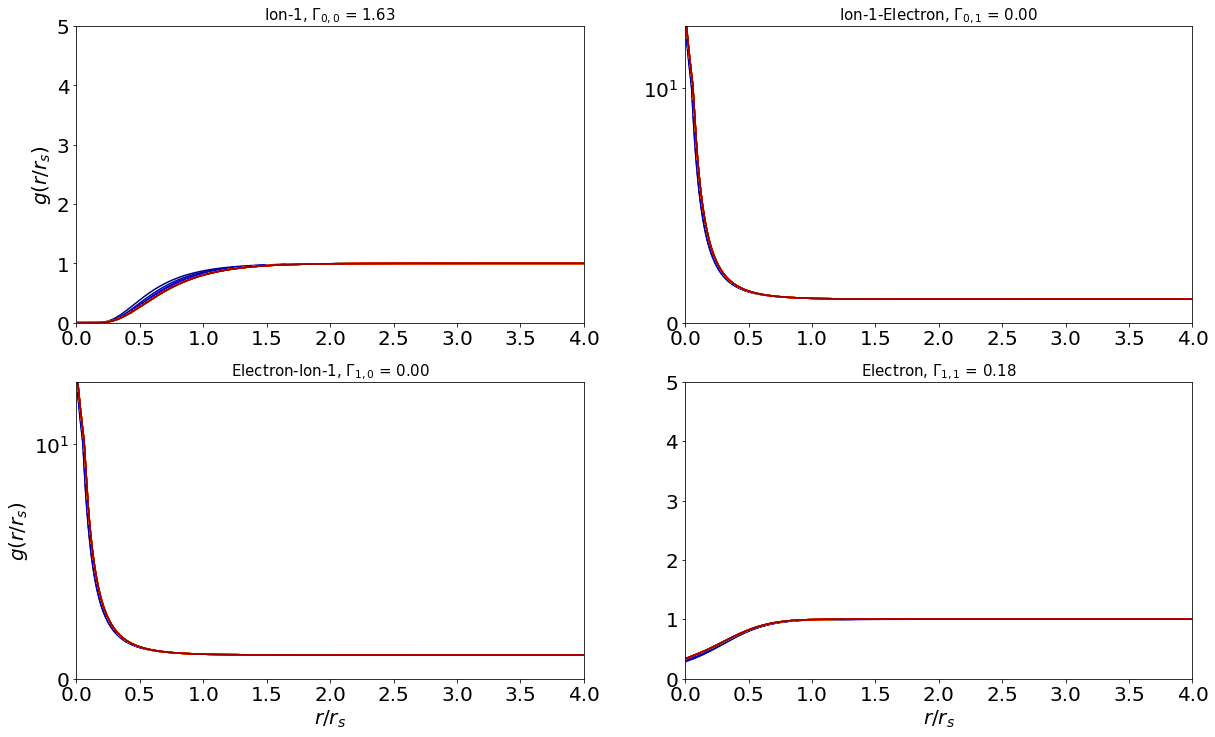

In [7]:
hnc2.plot_species_convergence(n_slices= int(len(hnc2.h_list)/1)  )

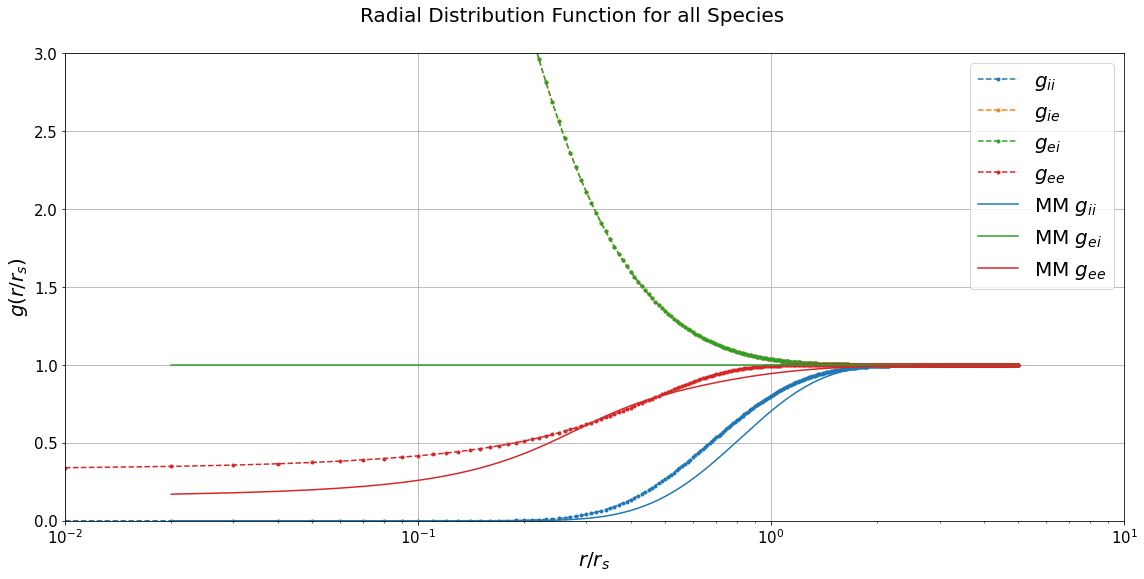

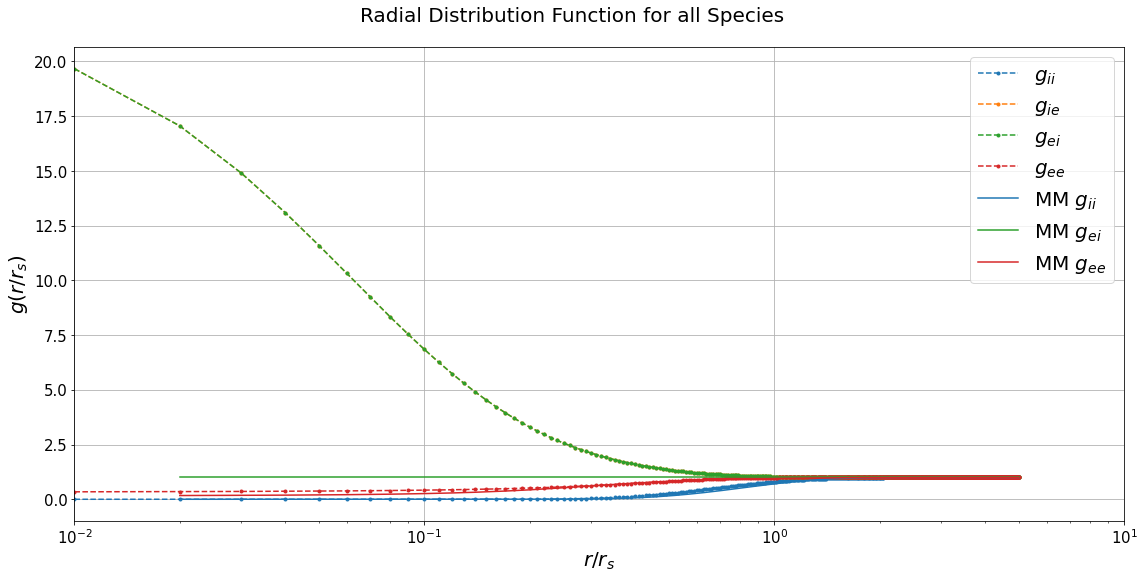

In [8]:
hnc2.plot_g_vs_murillo(gmax=3)
hnc2.plot_g_vs_murillo()

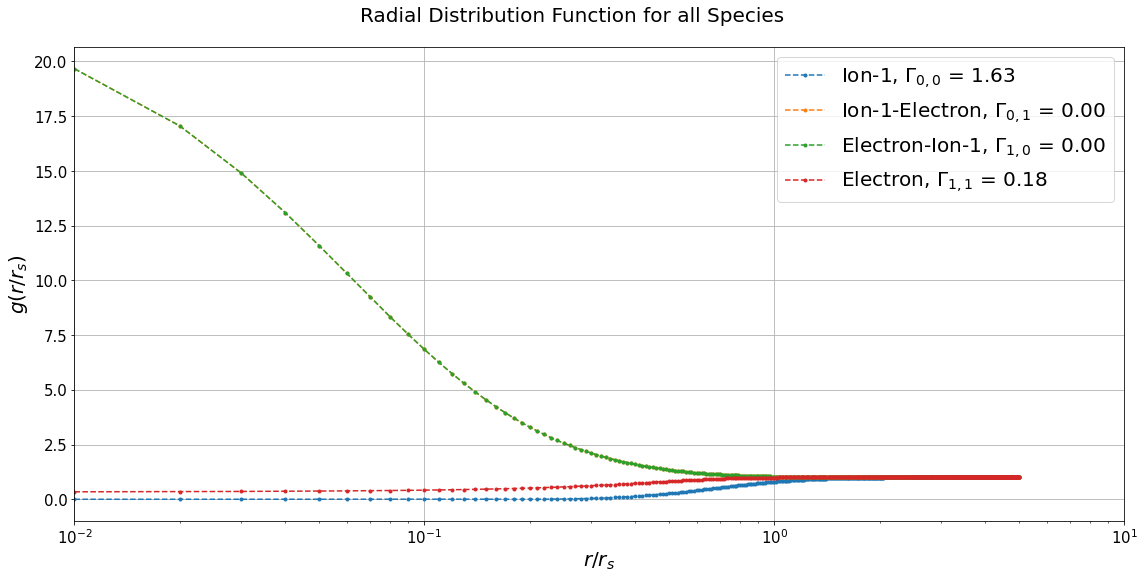

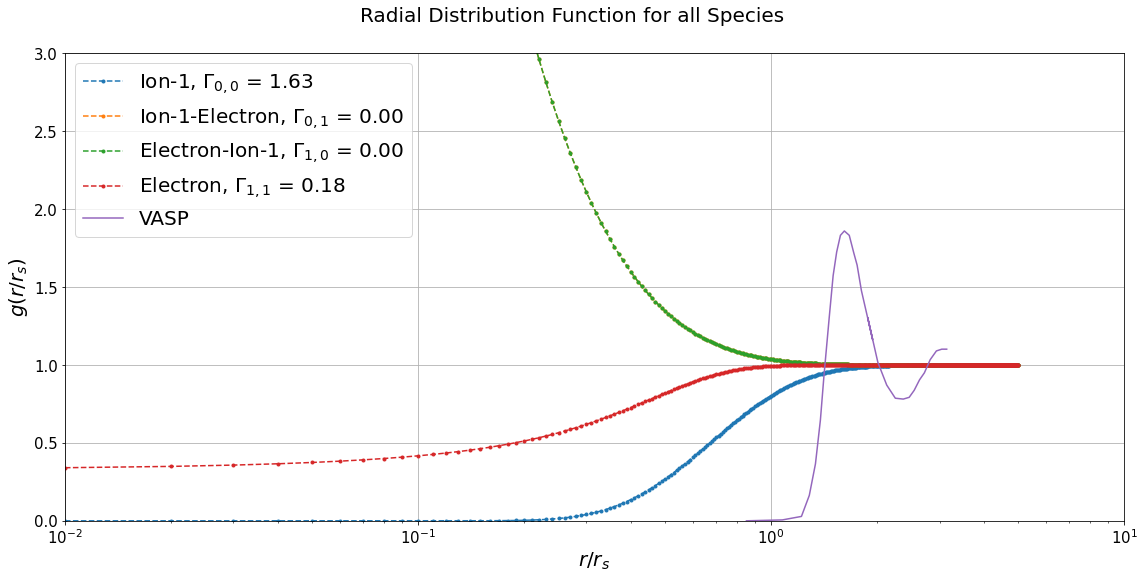

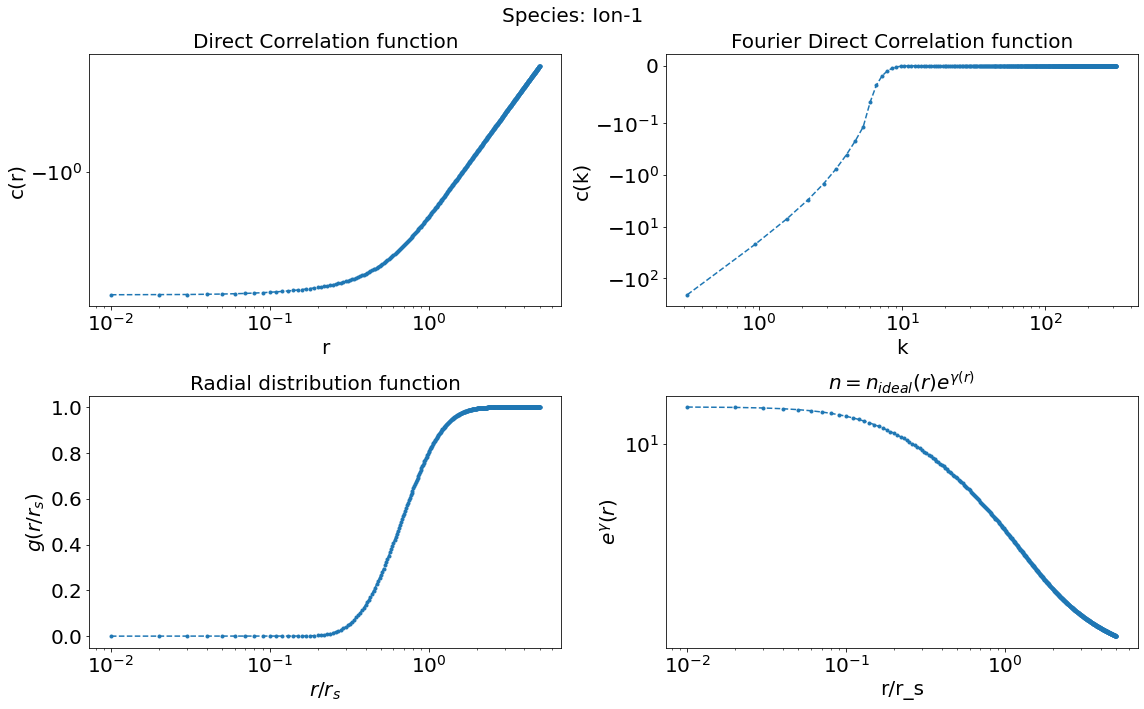

In [9]:
hnc2.plot_g_all_species()
# hnc2.plot_g_all_species(gmax=3,data_to_compare=['/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt'], data_names=['VASP'])
hnc2.plot_g_all_species(gmax=3,data_to_compare=['/home/zach/plasma/datasets/RDFs/Al_0.5eV_rs3_KS-MD.txt'], data_names=['VASP'])
hnc2.plot_species((0,0))


In [10]:
# np.savetxt("/home/zach/Downloads/Al_1.0eV_r3_QSPHNC.txt",np.array([hnc2.r_array,hnc2.h_r_matrix[0,0]+1]).T)

# Effective Potentials

In [11]:
hnc_extended = HNC_solver(2, Gamma=Gamma, kappa=kappa, tol=1e-7,
                 kappa_multiscale=1, rho = rho, num_iterations=int(1e0), 
                 R_max=10, N_bins=500, names=names, dst_type=3)

hnc_extended.βω_r_matrix = np.zeros_like(hnc_extended.h_r_matrix)
hnc_extended.βω_r_matrix[:,:, :hnc2.N_bins] = hnc2.βω_r_matrix

In [12]:
hnc2.invert_HNC(1)

In [13]:
# fig, ax = plt.subplots()

# ax.plot(hnc2.r_array, 1+hnc2.heff_r_matrix[0,0],label= 'h')
# ax.plot(hnc2.r_array, hnc2.ceff_r_matrix[0,0],label='c')
# ax.plot(hnc2.r_array,np.log(1+hnc2.heff_r_matrix)[0,0],label='log(1+h)')
# ax.set_yscale('symlog',linthresh=1e-5)
# ax.set_xlim(1e-1,2)
# # ax.set_xscale('log')
# ax.legend()

In [14]:
Te = qsp.Ti
from pandas import read_csv
from scipy.interpolate import interp1d
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
luke_r, luke_βV = 1e-10/aB/ri*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r[165], luke_βV[165]
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

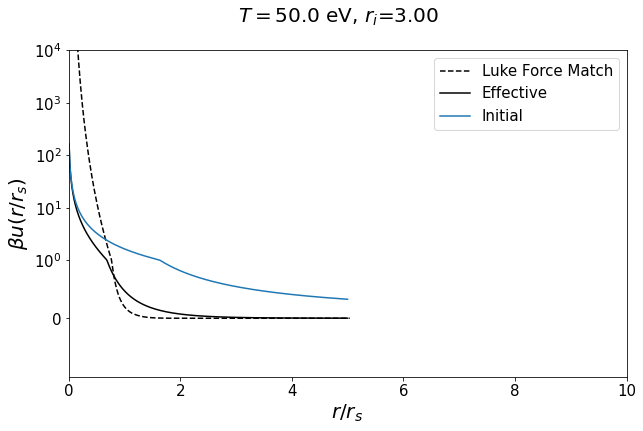

In [15]:
fig, ax = plt.subplots(figsize=(10,6),facecolor='w')
fig.suptitle(r"$T=${0:.1f} eV, $r_i$={1:.2f}".format(Te/eV,ri), fontsize=20)

ax.plot(luke_r, luke_βV,'k--', label="Luke Force Match")
ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0],'k-', label="Effective")
ax.plot(hnc2.r_array, hnc2.βu_r_matrix[0,0], label="Initial")
# ax.plot(hnc_extended.r_array, hnc_extended.βueff_r_matrix[0,0],'k-', label="Effective")
# ax.plot(hnc_extended.r_array, hnc_extended.βu_r_matrix[0,0], label="Initial")
# ax.plot(hnc2.r_array, qsp.βv_Yukawa(hnc2.r_array),label="Yukawa")
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(-1,1e4)
ax.set_xlim(0,10)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

# Check!

In [16]:
# I_plus_h_rho_inverse = hnc2.invert_matrix(hnc2.I[:,:,np.newaxis] + hnc2.heff_k_matrix*hnc2.rhoeff[:,np.newaxis,np.newaxis])
# hnc2.ceff_k_matrix = hnc2.A_times_B(I_plus_h_rho_inverse, hnc2.heff_k_matrix)[0,0]
# hnc2.ceff_r_matrix = hnc2.FT_k_2_r_matrix(hnc2.ceff_k_matrix)

# # Approximate with HNC
# hnc2.βueff_r_matrix = hnc2.heff_r_matrix - hnc2.ceff_r_matrix + hnc2.βωeff_r_matrix


In [17]:
N_species = 1
Gamma = np.array(  [[1]])
names = ["Ion Effective"] 
kappa = 1
rho = np.array([3/(4*np.pi)])
hnc_check = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, kappa_multiscale=1,
                       rho = rho, num_iterations=int(1e4), R_max=10, N_bins=500, names=names)


# check
βu_r_matrix = np.nan_to_num( hnc2.βueff_r_matrix,nan = -np.log(1.e-16), posinf=-np.log(1e-16) ).copy()
hnc_check.set_βu_matrix(βu_r_matrix)
hnc_check.c_k_matrix = hnc2.ceff_k_matrix
hnc_check.HNC_solve(alpha_method='fixed')


0: Err in c_r: 2.64e-01, OZ: 1.46e+00, HNC: 1.77e-02
1: Err in c_r: 2.34e-01, OZ: 4.51e-01, HNC: 3.31e-02
2: Err in c_r: 2.11e-01, OZ: 4.48e-01, HNC: 3.13e-02
3: Err in c_r: 1.90e-01, OZ: 4.45e-01, HNC: 2.94e-02
4: Err in c_r: 1.72e-01, OZ: 4.42e-01, HNC: 2.77e-02
5: Err in c_r: 1.55e-01, OZ: 4.39e-01, HNC: 2.60e-02
6: Err in c_r: 1.40e-01, OZ: 4.37e-01, HNC: 2.43e-02
7: Err in c_r: 1.26e-01, OZ: 4.35e-01, HNC: 2.28e-02
8: Err in c_r: 1.14e-01, OZ: 4.33e-01, HNC: 2.13e-02
9: Err in c_r: 1.02e-01, OZ: 4.31e-01, HNC: 1.98e-02
10: Err in c_r: 9.21e-02, OZ: 4.30e-01, HNC: 1.85e-02
11: Err in c_r: 8.30e-02, OZ: 4.28e-01, HNC: 1.72e-02
12: Err in c_r: 7.47e-02, OZ: 4.27e-01, HNC: 1.60e-02
13: Err in c_r: 6.73e-02, OZ: 4.26e-01, HNC: 1.49e-02
14: Err in c_r: 6.06e-02, OZ: 4.25e-01, HNC: 1.38e-02
15: Err in c_r: 5.45e-02, OZ: 4.24e-01, HNC: 1.28e-02
16: Err in c_r: 4.90e-02, OZ: 4.24e-01, HNC: 1.19e-02
17: Err in c_r: 4.41e-02, OZ: 4.23e-01, HNC: 1.10e-02
18: Err in c_r: 3.97e-02, OZ: 4.22e-01

In [18]:
# #luke
# hnc_luke = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-5, kappa_multiscale=0.5,
#                        rho = rho, num_iterations=int(1e4), R_max=10, N_bins=500, names=names)

# βu_r_matrix[0,0]=  np.where( luke_βV_function(hnc2.r_array)>1e4, 1e4, luke_βV_function(hnc2.r_array) )
# hnc_luke.set_βu_matrix(βu_r_matrix)
# hnc_luke.HNC_solve(alpha_method='fixed', alpha_Picard=1e-3, alpha_oz=1e-3)


In [19]:
# np.savetxt("example_veff_1eV_rs_3aBohr.txt", np.array([hnc_check.r_array, hnc_check.βu_r_matrix[0,0]]).T,header="r/r_s,   beta v_ii^eff   (both unitless)",delimiter=', ' )

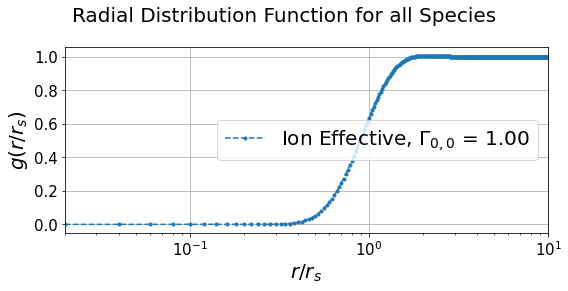

In [20]:
hnc_check.plot_g_all_species()

NameError: name 'hnc_luke' is not defined

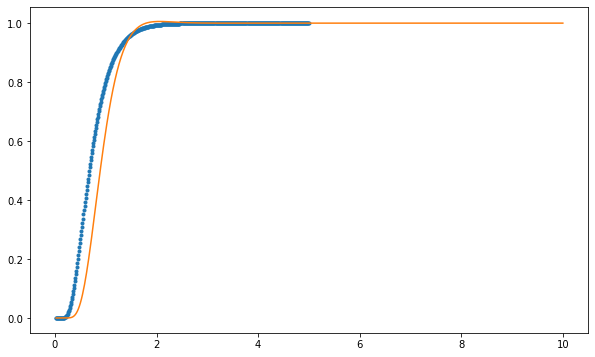

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(hnc2.r_array, hnc2.h_r_matrix[0,0]+1,'.', label="Two Actual Species")
ax.plot(hnc_check.r_array, hnc_check.h_r_matrix[0,0]+1,'-', label="One Effective Species")
ax.plot(hnc_luke.r_array, hnc_luke.h_r_matrix[0,0]+1,'-', label="Luke HNC with Force Matched V")
ax.set_ylabel(r'$g(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(-0.1,3)
ax.set_xlim(0,5)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

# Curve Fitting

In [ ]:
from scipy.optimize import curve_fit

def yukawa_fit(r, Γ, κ,p):
    return  Γ/r*np.exp(-κ*r)

def yukawa_remaining_fit(r,a,b,c,d):
    return 1/(a+b*np.exp(c*(hnc2.r_array-d)))

def LJ_fit(r, a,b,m,n):
    return  1/(a*r**m + b/r**n) #+ v0

def yukawa_friedel_fit(r, Γ, κ1, a,κ2, k,  δ, v0):
    return  Γ/r*np.exp(-κ1*r) + a/r**3*np.exp(-κ2*r)*np.cos(k*r+δ) + v0

def yukawa_plus_fit(r, Γ, κ1, a,b,c):
    return  Γ/r*np.exp(-κ1*r)/(1+np.exp(b*(hnc2.r_array-c)))
# last_inf_index = int(np.argwhere(np.isinf(hnc2.βueff_r_matrix[0,0]))[-1] )

y_vals = curve_fit(yukawa_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0])
y_fit_data  = yukawa_fit(hnc2.r_array, y_vals[0][0],y_vals[0][1],y_vals[0][2])

y_remaining_vals = curve_fit(yukawa_remaining_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0]/y_fit_data)
y_remaining_fit_data  = yukawa_remaining_fit(hnc2.r_array, y_remaining_vals[0][0],y_remaining_vals[0][1],y_remaining_vals[0][2],y_remaining_vals[0][3])


# LJ_vals = curve_fit(LJ_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e5))
# yf_vals= curve_fit(yukawa_friedel_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e5))
# yp_vals= curve_fit(yukawa_plus_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e3))

In [ ]:
y_vals[0], y_remaining_vals[0]

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

g_data = hnc2.h_r_matrix[0,0] + 1

# LJ_fit_data  = LJ_fit(hnc2.r_array, LJ_vals[0][0],LJ_vals[0][1],LJ_vals[0][2],LJ_vals[0][3])
# yf_fit_data = yukawa_friedel_fit(hnc2.r_array, yf_vals[0][0],yf_vals[0][1],yf_vals[0][2],yf_vals[0][3],yf_vals[0][4],yf_vals[0][5],yf_vals[0][6])
# yp_fit_data = yukawa_plus_fit(hnc2.r_array, yp_vals[0][0],yp_vals[0][1],yp_vals[0][2],yp_vals[0][3],yp_vals[0][4])


ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0],'k-', label="Effective")
# ax.plot(hnc2.r_array, y_fit_data*y_remaining_fit_data,'--', label="Yukawa Fit")
ax.plot(hnc2.r_array, 81.87504124/hnc2.r_array*np.exp(-0.99115223*hnc2.r_array)/(0.92620556+0.7351028*np.exp(1.72217623*(hnc2.r_array-1.75197859))),'--', label="Fit")
# ax.plot(hnc2.r_array[1:], hnc2.βueff_r_matrix[0,0][1:]-hnc2.βueff_r_matrix[0,0][:-1],'k-', label="Effective")
# ax.plot(hnc2.r_array[1:], (y_fit_data*y_remaining_fit_data)[1:]-(y_fit_data*y_remaining_fit_data)[:-1],'--', label="Yukawa Fit")

# ax.plot(hnc2.r_array, LJ_fit_data,'--', label="Yukawa Fit")
# ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0]-y_fit_data*y_remaining_fit_data,'.', label="Yukawa Fit Ratio")
 
# ax.plot(hnc2.r_array,y_remaining_fit_data,'.', label="Yukawa Remaining Fit")

# ax.plot(hnc2.r_array, yf_fit_data,'.', label="Yukawa-Friedel Fit")
# ax.plot(hnc2.r_array, yp_fit_data,'.', label="Yukawa-Plus Fit")
# ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0]/yp_fit_data,'.', label="Yukawa-Plus Fit Ratio")
# ax.plot(hnc2.r_array, 1/(1+np.exp(3*(hnc2.r_array-2.5))),'.', label="Yukawa-Friedel Fit")

ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(-2,2)
ax.set_yscale('symlog',linthresh=1e-1)
ax.set_xlim(0,10)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

In [ ]:
from scipy.interpolate import RBFInterpolator



RBFInterpolator(hnc2.r_array, hnc2.βueff_r_matrix[0,0]/y_fit_data)